In [2]:
!python -m pip install ucimlrepo
!python -m pip install torch
!python -m pip install pykan



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#this is usesless
from ucimlrepo import fetch_ucirepo 
import numpy as np
import matplotlib.pyplot as plt
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 
  
# metadata 
print(air_quality.metadata) 
  
# variable information 
print(air_quality.variables) 


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

In [4]:
print(X.head())
columns_extract = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)'
       ,'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH']

        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4 

In [5]:
data = X[columns_extract].to_numpy()

In [6]:
data_min = np.min(data, axis=0)
data_max = np.max(data, axis=0)
normalized_data_column = (data - data_min) / (data_max - data_min)

In [7]:
print(data[2000:4000,2])

[-200. -200. -200. ... -200. -200. -200.]


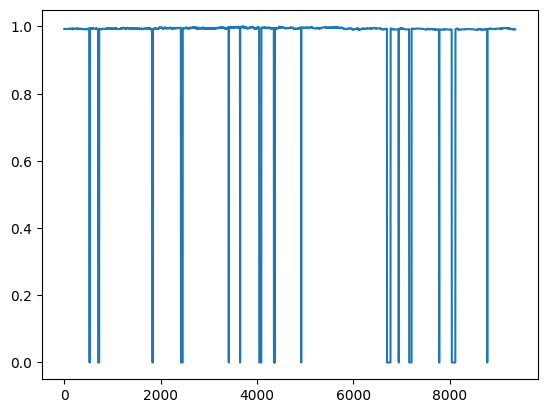

In [8]:
plt.plot(normalized_data_column[:,12])

In [9]:
from kan import *
import torch

loss_fn = lambda x, y: torch.mean((x - y) ** 2)
def model_routine(model, dataset):
    model.fit(dataset, opt="LBFGS", steps=10, loss_fn = loss_fn)
    #plot_model(model)
    return model
    
def test_refinment(model, dataset):    
    model = model.refine(10)
    model.fit(dataset, opt="LBFGS", steps=20, loss_fn = loss_fn)
    #plot_model(model)
    return model

In [10]:
def model_refinement(width, dataset):
    pprint = copy.deepcopy(width)
    grids = np.array([3,10,20,35])
    #grids = np.array([50])
    models = []
    train_losses = []
    test_losses = []
    test_loss = []
    train_loss = []
    steps = 200
    k = 3
    for i in range(grids.shape[0]):
        print(grids[i])
        if i == 0:
            model = KAN(width=width, grid=grids[i], k=3, seed=0)
        if i != 0:
            model = model.refine(grids[i])
        results = model.fit(dataset, opt="LBFGS", steps=steps, loss_fn = loss_fn)
        train_loss += results['train_loss']
        test_loss += results['test_loss']
        train_losses.append(results['train_loss'])
        test_losses.append(results['test_loss'])
        models.append(model)

        #plot_model(model)
    plt.title(f"Model with Grid size {grids[i]} and compressionshape {pprint}")
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train', 'test'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')
    path = os.path.join("plots",f"G_{grids[i]}_w_{pprint}_t_{steps}.png"  )
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()
    return models, train_losses, test_losses

In [11]:
model = KAN(width=[13,3,13], grid=3, k=3, seed = 2)


checkpoint directory created: ./model
saving model version 0.0


In [12]:
shuffled_data = np.random.permutation(normalized_data_column)
index = int(data.shape[0] * 0.8)

In [13]:
dataset = {
    'train_input':torch.tensor(shuffled_data[:index], dtype = torch.float32),
    'test_input':torch.tensor(shuffled_data[index:], dtype = torch.float32),
    'train_label':torch.tensor(shuffled_data[:index], dtype = torch.float32),
    'test_label':torch.tensor(shuffled_data[index:], dtype = torch.float32)
}

In [14]:
model = model_routine(model, dataset)

| train_loss: 7.35e-02 | test_loss: 7.33e-02 | reg: 2.56e+01 | : 100%|█| 10/10 [00:25<00:00,  2.55s/

saving model version 0.1


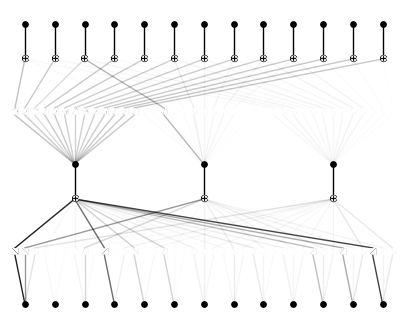

In [15]:
model.plot()

In [16]:
model = test_refinment(model, dataset)

saving model version 0.2


| train_loss: 3.25e-02 | test_loss: 3.40e-02 | reg: 2.94e+01 | : 100%|█| 20/20 [00:53<00:00,  2.66s/

saving model version 0.3


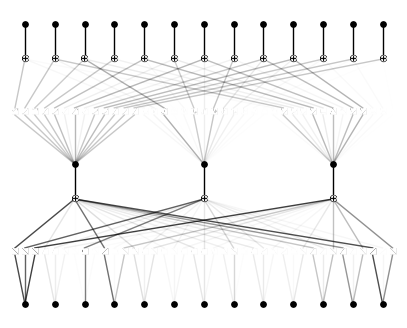

In [17]:
model.plot()

In [18]:
def test_model(model, test_dataloader):
    criterion = nn.MSELoss()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        return loss

In [19]:
import torch.optim as optim
def fit(model,dataloader, test_dataloader, epochs=100, lr=0.001):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 10*len(dataloader))
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = lambda x, y: torch.mean((x - y) ** 2)
    #criterion = nn.MSELoss(reduction='mean')
    model.train()
    loss_list = []
    test_loss_list = []
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, targets in dataloader:
            #print(scheduler.get_lr())
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            loss.backward()
            for models in model.enc.layers:
                models.multiply_grad_masks()
            optimizer.step()
            scheduler.step()
        avg_loss = total_loss / len(dataloader)
        loss_list.append(avg_loss)
        test_loss = test_model(model, test_dataloader)
        avg_test_loss = test_loss / len(dataloader)
        test_loss_list.append(test_loss)
        print(f"Epoch [{epoch + 1}/{epochs}],Average Loss: {avg_loss:.7f}, Test Loss: {test_loss:.7f}")
    plt.title(f"Model with Grid size {model.shape} and compressionshape {model.h_in}")
    plt.plot(loss_list)
    plt.plot(test_loss_list)
    plt.legend(['train', 'test'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')
    path = os.path.join("plots",f"neural_kan_{model.shape}_t_{epochs}.png")
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
from Kan_NN import Neural_Kan
class compressed_sensor(nn.Module):
    def __init__(self, shape, h_in, out_shape):
        super(compressed_sensor, self).__init__()
        self.shape = shape
        self.h_in = h_in
        self.enc = Neural_Kan(shape = self.shape, h = self.h_in)
        layers = []
        for i in range(len(out_shape) - 1):
            layers.append(nn.Linear(out_shape[i], out_shape[i + 1]))  # Add a Linear layer
            layers.append(nn.ReLU())  # Add ReLU activation after each Linear layer
            
        # Remove the last ReLU after the output layer
        layers = layers[:-1]  # Remove the last ReLU since it's the output layer
        
        # Convert the list of layers into a Sequential model
        self.dec = nn.Sequential(*layers)
        print(self.dec)
    def forward(self, x):
        encoded = self.enc(x)
        return self.dec(encoded)

In [21]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(dataset['train_input'], dataset['train_label'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(dataset['test_input'], dataset['test_label'])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(dataset['test_input']), shuffle=True)


13 5
Sequential(
  (0): Linear(in_features=13, out_features=208, bias=True)
  (1): ReLU()
  (2): Linear(in_features=208, out_features=416, bias=True)
  (3): ReLU()
  (4): Linear(in_features=416, out_features=832, bias=True)
  (5): ReLU()
  (6): Linear(in_features=832, out_features=416, bias=True)
  (7): ReLU()
  (8): Linear(in_features=416, out_features=208, bias=True)
  (9): ReLU()
)
Sequential(
  (0): Linear(in_features=5, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=13, bias=True)
)
Epoch [1/200],Average Loss: 0.0726501, Test Loss: 0.0275011
Epoch [2/200],Average Loss: 0.0166526, Test Loss: 0.0085820
Epoch [3/200],Average Loss: 0.0073787, Test Loss: 0.0055632
Epoch [4/200],Average Loss: 0.0043831, Test Loss: 0.0039608
Epoch [5/200]

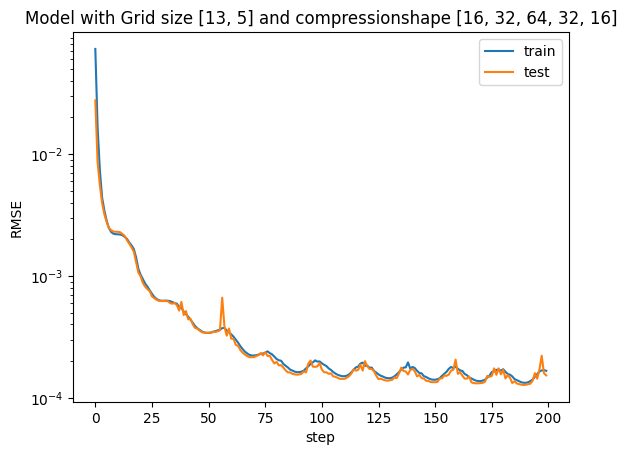

In [30]:
epochs = 200
for i in range(1,14):
    model = compressed_sensor(shape = [13,i], h_in = [16,32,64,32,16], out_shape = [i, 16, 32, 64,32,13])
    fit(model,train_dataloader, test_dataloader, epochs=epochs, lr=0.001)

In [24]:
for i in range(1,2):
    #model = KAN(width=[13,i,13], grid=3, k=3, seed = 2)
    model_dict[i] = model_refinement([13,i,13], dataset=dataset)
import pickle
with open('model_dict.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

3
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 1.54e-01 | test_loss: 1.61e-01 | reg: 0.00e+00 | :   0%| | 1/200 [00:02<09:22,  2.83s/


KeyboardInterrupt: 

In [25]:
i = 5
#print(dataset['test_input'], model(dataset['test_input']))
#max(torch.linalg.norm(dataset['test_input'] - model(dataset['test_input']).detach(), axis = 1))
print(torch.max(dataset['test_input'] - model(dataset['test_input']).detach()))
print(torch.where(dataset['test_input'] - model(dataset['test_input']).detach() > 0.2))

print(dataset['test_input'][i] - model(dataset['test_input']).detach()[i])

tensor(0.8613)
(tensor([   2,    4,    4,  ..., 1865, 1867, 1871]), tensor([6, 1, 4,  ..., 2, 6, 5]))
tensor([ 0.1589, -0.0040, -0.0541,  0.0081,  0.0178,  0.0618,  0.2411,  0.0995,
        -0.0183,  0.0069, -0.0152,  0.1015,  0.0054])


Epoch [1/100], Loss: 0.0210
Epoch [2/100], Loss: 0.0052
Epoch [3/100], Loss: 0.0032
Epoch [4/100], Loss: 0.0020
Epoch [5/100], Loss: 0.0014
Epoch [6/100], Loss: 0.0011
Epoch [7/100], Loss: 0.0011
Epoch [8/100], Loss: 0.0010
Epoch [9/100], Loss: 0.0012
Epoch [10/100], Loss: 0.0012
Epoch [11/100], Loss: 0.0010
Epoch [12/100], Loss: 0.0009
Epoch [13/100], Loss: 0.0013
Epoch [14/100], Loss: 0.0007
Epoch [15/100], Loss: 0.0007
Epoch [16/100], Loss: 0.0006
Epoch [17/100], Loss: 0.0008
Epoch [18/100], Loss: 0.0008
Epoch [19/100], Loss: 0.0004
Epoch [20/100], Loss: 0.0004
Epoch [21/100], Loss: 0.0005
Epoch [22/100], Loss: 0.0004
Epoch [23/100], Loss: 0.0004
Epoch [24/100], Loss: 0.0004
Epoch [25/100], Loss: 0.0009
Epoch [26/100], Loss: 0.0004
Epoch [27/100], Loss: 0.0010
Epoch [28/100], Loss: 0.0005
Epoch [29/100], Loss: 0.0004
Epoch [30/100], Loss: 0.0004
Epoch [31/100], Loss: 0.0004
Epoch [32/100], Loss: 0.0004
Epoch [33/100], Loss: 0.0003
Epoch [34/100], Loss: 0.0004
Epoch [35/100], Loss: 0

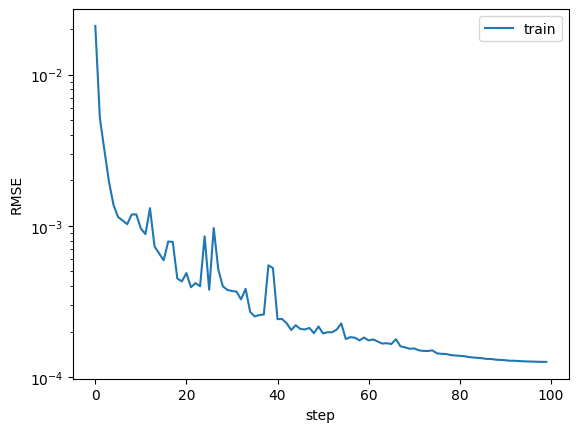

In [29]:
class Encoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Encoder, self).__init__()
        self.bottleneck_dim = bottleneck_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(13, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, bottleneck_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 13)
        )

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return reconstructed

def train(model, train_loader, epochs=20, lr=1e-3, bottleneck_size=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    loss_list = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for data,_ in train_loader:
            inputs = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        loss_list.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.7f}")
    plt.plot(loss_list)
    plt.legend(['train', 'test'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')
    plt.show()
    

bottleneck_size = 5
model = Encoder(bottleneck_size)
train(model, train_dataloader, epochs=100, lr=1e-2, bottleneck_size=bottleneck_size)
